```
This software is part of GPU Ocean. 

Copyright (C) 2017, 2018 SINTEF Digital
Copyright (C) 2017, 2018 Norwegian Meteorological Institute

This notebook implements the Rossby adjustment test case, as 
reported under Case B in Test Cases for Rotational Shallow-Water Schemes 
by Holm, Brodtkorb, Broström, Christensen and Sætra.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# Investing symmetric properties of the different schemes

This notebook is based on the Rossby adjustment test case, and investigate the symmetry obtained by the different numerical schemes.

# Setting up the environment

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#Import packages we need
import numpy as np
from matplotlib import animation, rc
from matplotlib import pyplot as plt
from matplotlib import gridspec as gridspec

import os, datetime, sys, subprocess
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))

from importlib import reload

# requires netcdf4-python (netcdf4-python.googlecode.com)
from netCDF4 import Dataset as NetCDFFile

#Set large figure sizes
rc('figure', figsize=(16.0, 12.0))
rc('animation', html='html5')

#Finally, import our simulator
from SWESimulators import FBL, CTCS, KP07, CDKLM16, SimWriter, PlotHelper, Common
from SWESimulators.BathymetryAndICs import *

In [2]:
gpu_ctx = Common.CUDAContext()

# Rossby adjustment on flat bottom

The area of interest is simply the neighbouring region around the initial bump (where  $\bar{\eta} \neq 0$ at steady state). We will therefore use a domain with open boundary conditions to allow gravity waves to escape the domain.

In [3]:
# Common parameters from Kai

nx = 600
ny = 600

dx = 50000
dy = 50000

dt = 100
g = 9.81
f = 1.2e-4
r = 0.0
H0 = 1000.0
A = 0.0 # A is diffusion coefficient multiplied by depth.

wind = Common.WindStress.WindStress()

# Using an open boundary
boundaryConditions = Common.BoundaryConditions(2,2,2,2)

ghosts = [2,2,2,2]
dataShape = (ny + ghosts[0]+ghosts[2], 
             nx + ghosts[1]+ghosts[3])
validDomain =  [2,2,2,2]


# Rossby adjustment parameters:
c0_squared = g*H0
a_squared = g*H0/(f*f)

T_steady_state = np.pi/f
print (T_steady_state)

#T = 300#sub_T = 4000.0

T = 2
sub_T = 500*dt
make_netCDF = False


interestingDomain = 250


sim_args = {
    'gpu_ctx': gpu_ctx,
    'nx': nx,
    'ny': ny,
    'dx': dx,
    'dy': dy,
    'dt': dt,
    'g' : g,
    'f' : f,
    'r' : r,
    'wind_stress': wind,
    'boundary_conditions': boundaryConditions,
    'write_netcdf': make_netCDF
}



26179.93877991494


In [4]:
def addWideDebugBump(eta, nx, ny, dx, dy, posx, posy, width_factor, halo):
    x_center = dx*(nx-1)*posx
    y_center = dy*(ny-1)*posy
    for j in range(-halo[2], ny + halo[0]):
        for i in range(-halo[3], nx + halo[1]):
            x = dx*i - x_center
            y = dy*j - y_center
            size = 500.0*min(dx, dy)*width_factor
            if (np.sqrt(x**2 + y**2) < size):
                eta[j+halo[2], i+halo[3]] += 0.2*np.exp(-(x**2/size+y**2/size))


In [5]:
def plot_symmetric(sim, title='', save=False):
    eta_fin, hu_fin, hv_fin = sim.download(interior_domain_only=True)

    fig = plt.figure(figsize=(7,7))
    #plt.imshow(eta_fin, origin='lower', interpolation='none')
    plt.imshow(eta_fin - eta_fin[::-1, ::-1], origin='lower', interpolation='none')
    plt.colorbar()
    if save:
        git_commit = str.strip(safe_call(['git', "log","--pretty=%H", "-n1"]))[:10]
        time_stamp = datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
        title = title + " - " + git_commit
    plt.title(title)
    if save:
        dir_name = "symmetric_cdklm"
        if not os.path.isdir(dir_name):
            os.makedirs(dir_name)
        fig.savefig(dir_name + "/" + time_stamp + "_" + git_commit + ".png")
    

# Helper function for running git commands
def safe_call(cmd, **kwargs):
    if (os.name == 'nt'):
        shell = True
    else:
        shell = False
    
    
    stdout = None
    try:
        stdout = subprocess.check_output(cmd, stderr=subprocess.STDOUT, shell=shell, **kwargs)
    except subprocess.CalledProcessError as e:
        output = e.output
        if isinstance(output, bytes):
            output = output.decode("utf-8")
        
    if isinstance(stdout, bytes):
        stdout = stdout.decode("utf-8")
    return stdout
    
    
print( datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S"))
print(str.strip(safe_call(['git', "log","--pretty=%H", "-n1"]))[:10])
    

2019_01_16-11_25_53
62dc797823


## Executing simulators

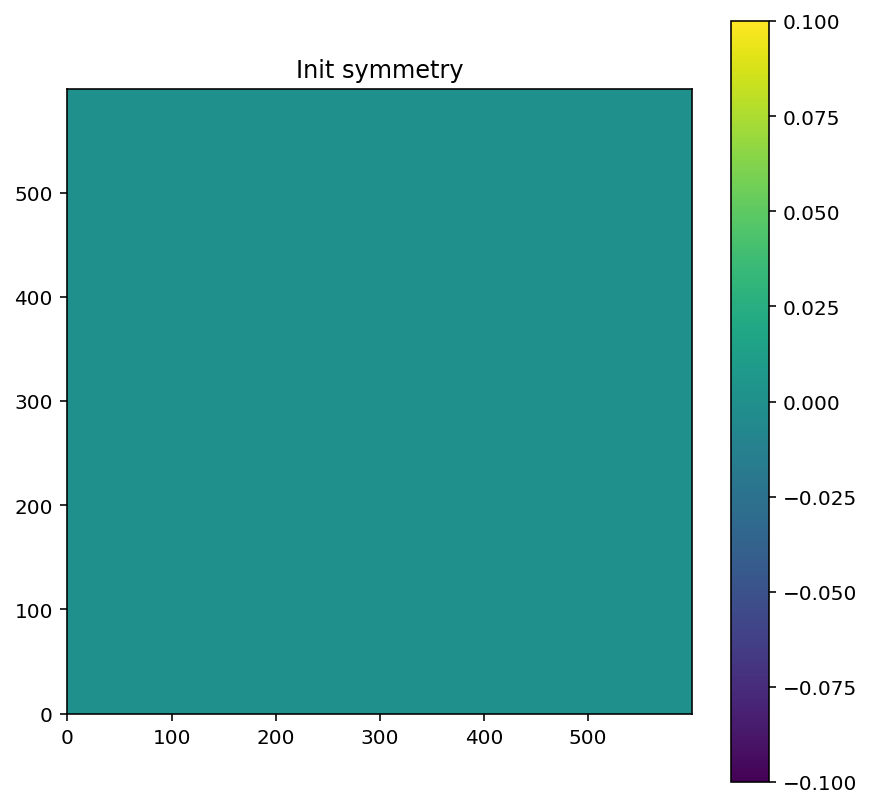

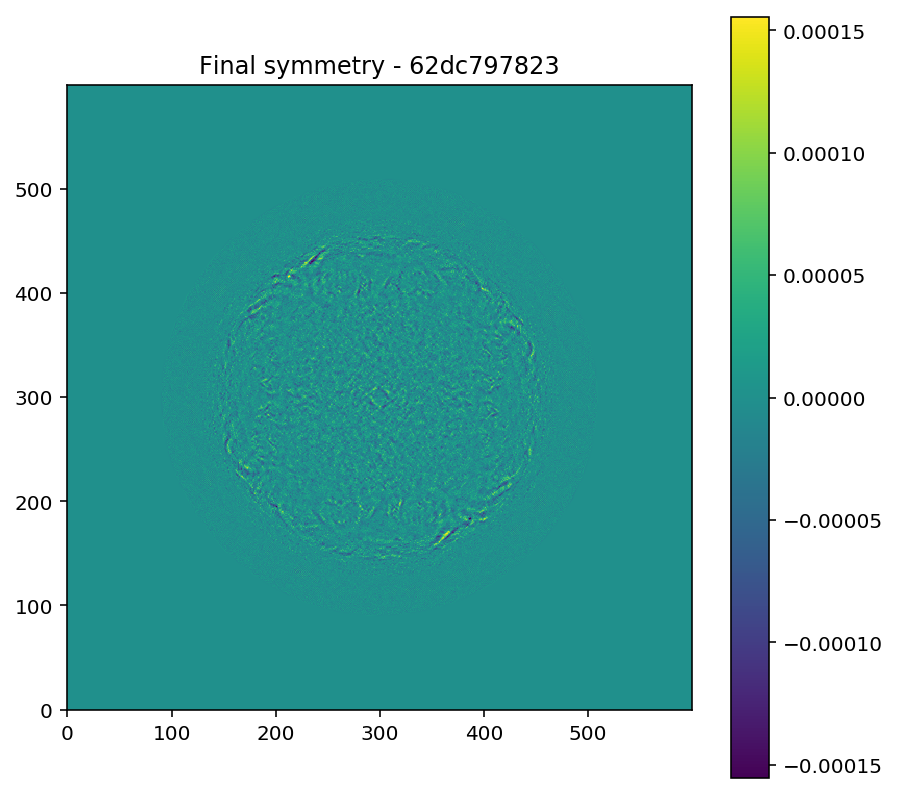

In [6]:
#Coriolis well balanced reconstruction scheme

cdklm_eta0 = np.zeros(dataShape, dtype=np.float32, order='C');
cdklm_u0   = np.zeros(dataShape, dtype=np.float32, order='C');
cdklm_v0   = np.zeros(dataShape, dtype=np.float32, order='C');

# Bathymetry:
Hi = np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32, order='C')*H0

#initialConditions(cdklm_eta0, nx, ny, dx, dy, ghosts[1], ghosts[0])#
addWideDebugBump(cdklm_eta0, nx, ny, dx, dy, 0.5, 0.5, 1e5, ghosts)





cdklm_args = {
    'rk_order': 2,
    'theta': 1.3,
}

init_args = {
    'eta0': cdklm_eta0,
    'hu0' : cdklm_u0,
    'hv0' : cdklm_v0,
    'H'   : Hi
}

#Initialize simulator
if 'cdklm_sim' in globals():
    cdklm_sim.cleanUp()
reload(CDKLM16)
cdklm_sim = CDKLM16.CDKLM16(**sim_args, **init_args, **cdklm_args)

plot_symmetric(cdklm_sim, "Init symmetry")

t = cdklm_sim.step(sub_T)


plot_symmetric(cdklm_sim, "Final symmetry", save=True)


In [7]:
#crash

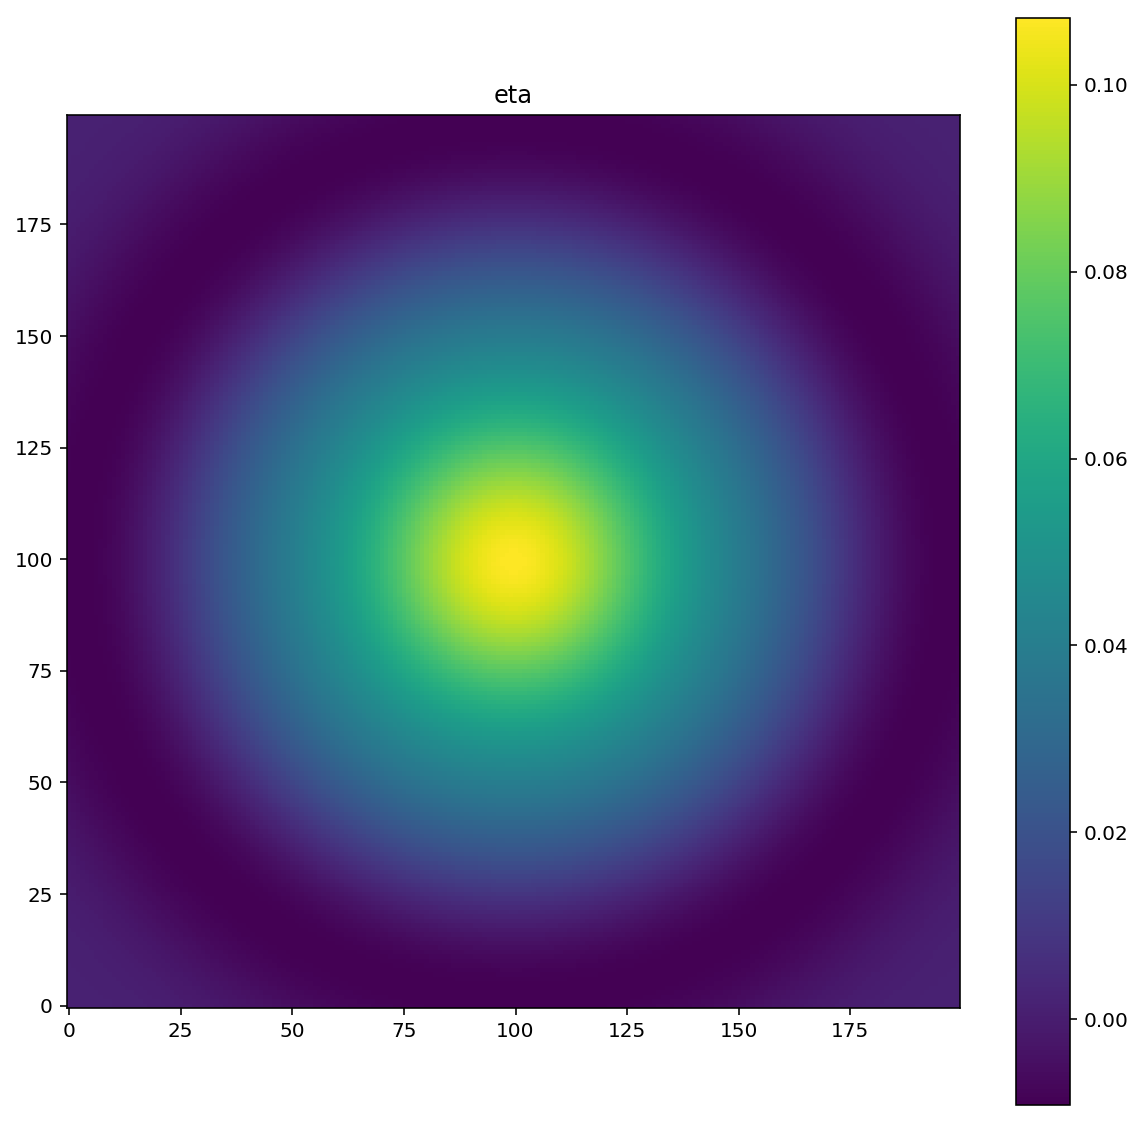

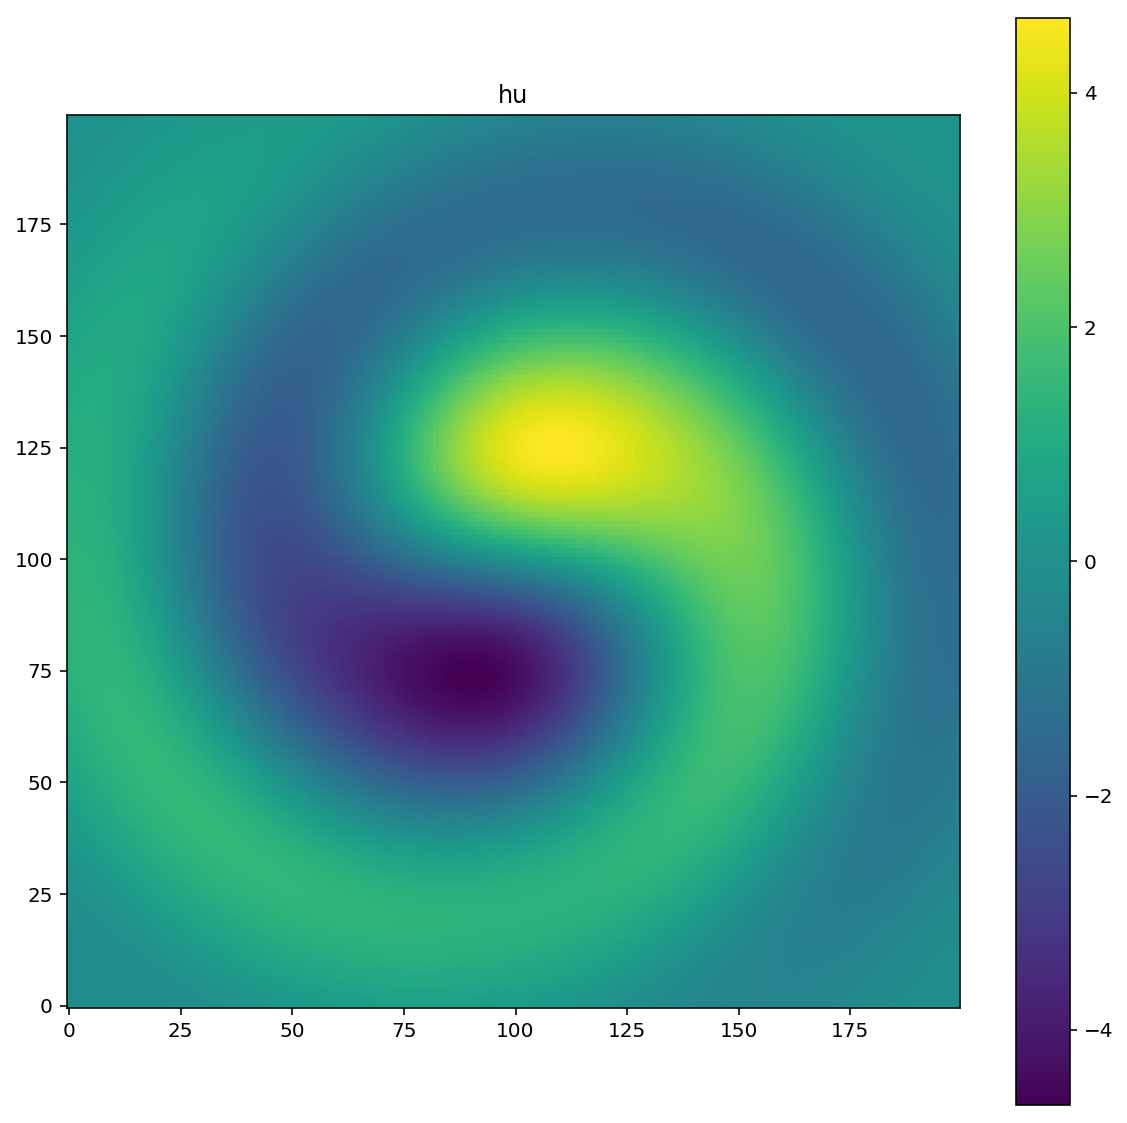

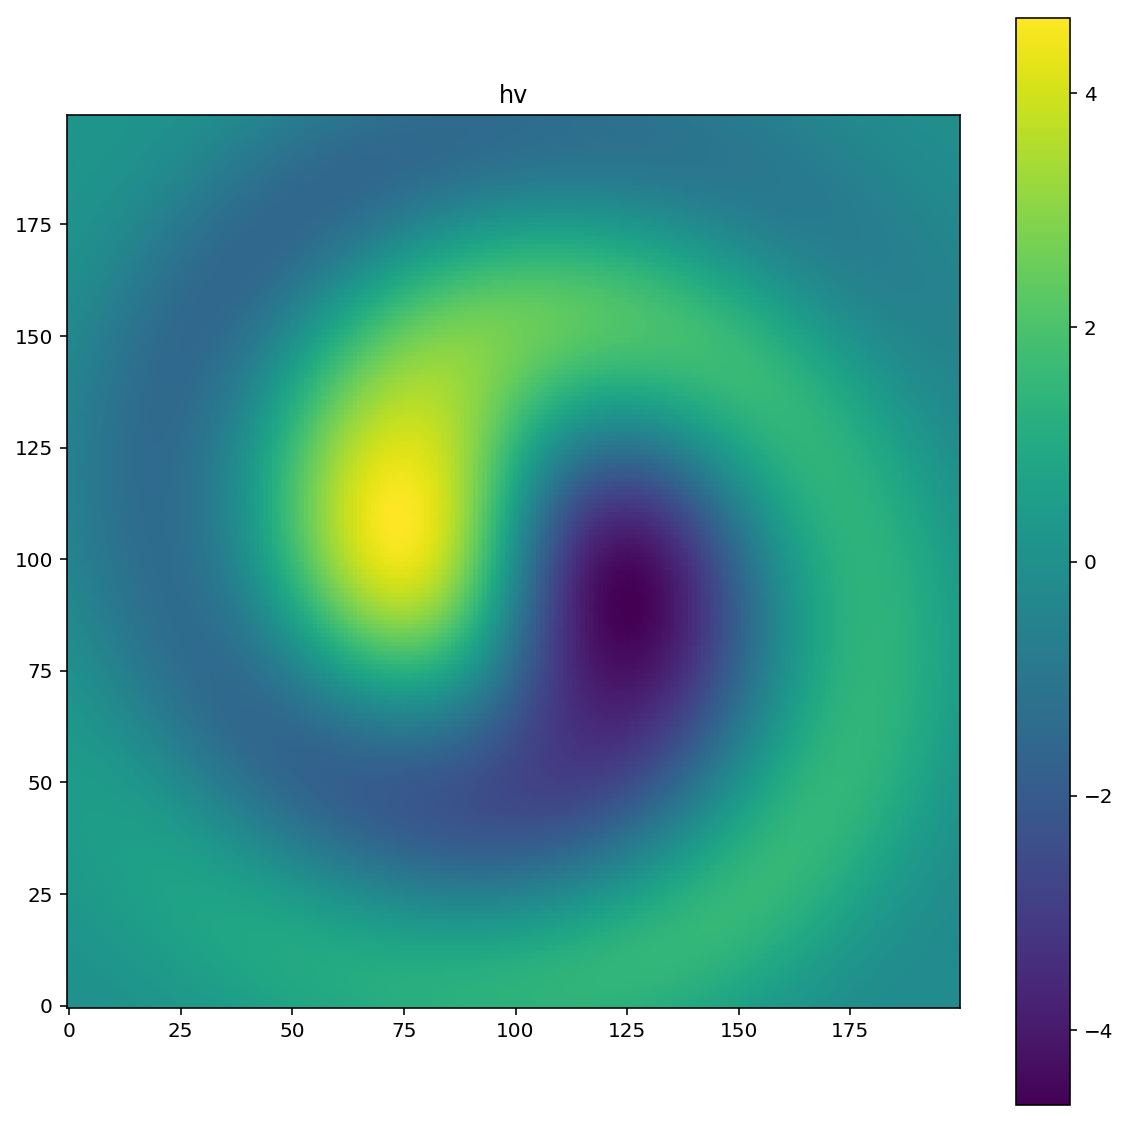

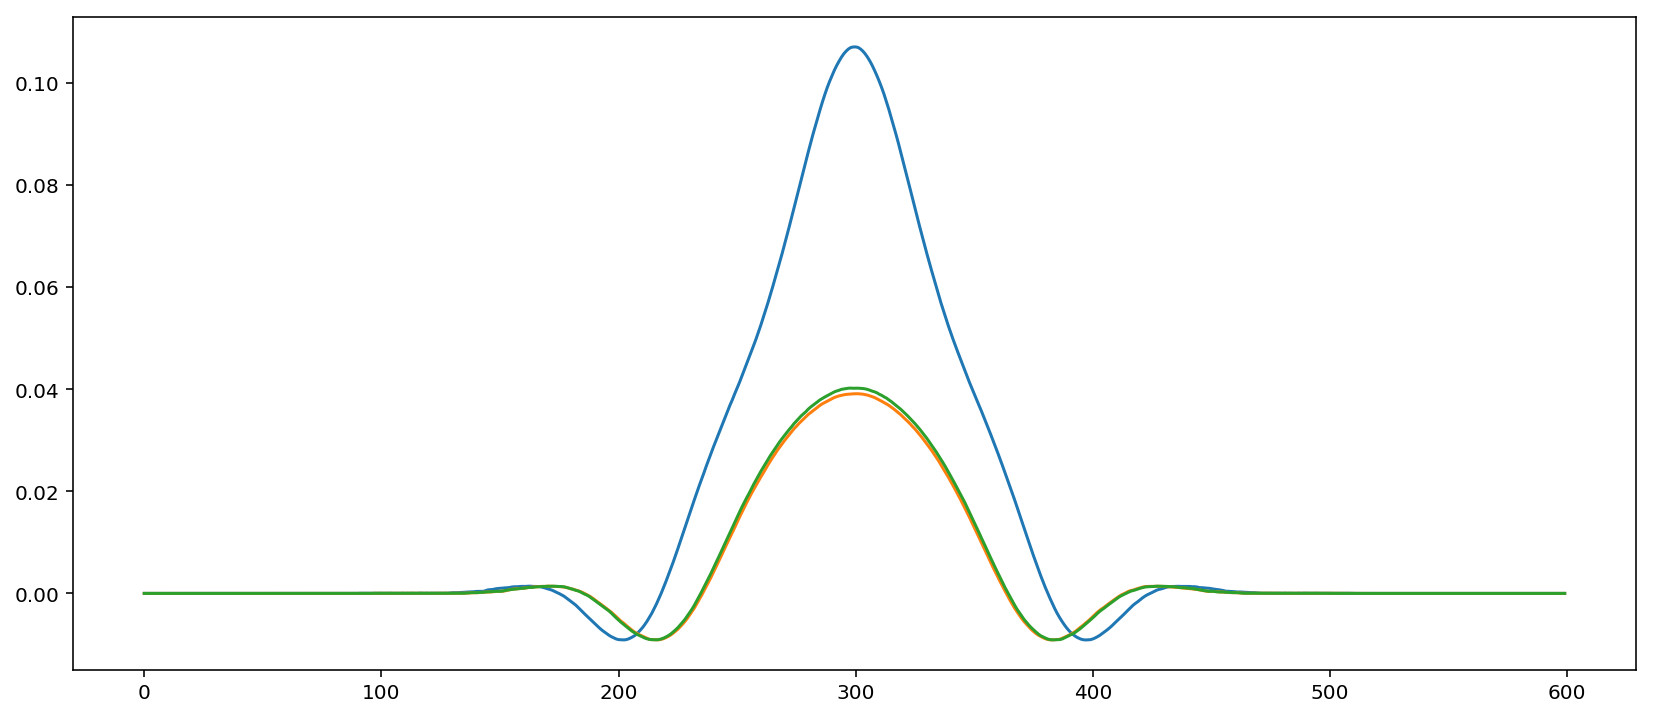

In [8]:
eta_fin, hu_fin, hv_fin = cdklm_sim.download(interior_domain_only=True)

for field, title in zip([eta_fin, hu_fin, hv_fin], ["eta", "hu", "hv"]):
    fig = plt.figure(figsize=(10,10))
    plt.imshow(field[200:400, 200:400], origin='lower', interpolation='none')
    plt.title(title)
    plt.colorbar()
    
fig = plt.figure(figsize=(14,6))
plt.plot(eta_fin[:,300])
plt.plot(eta_fin[:,350])
plt.plot(eta_fin[:,250])


In [9]:
cdklm_sim.cleanUp()


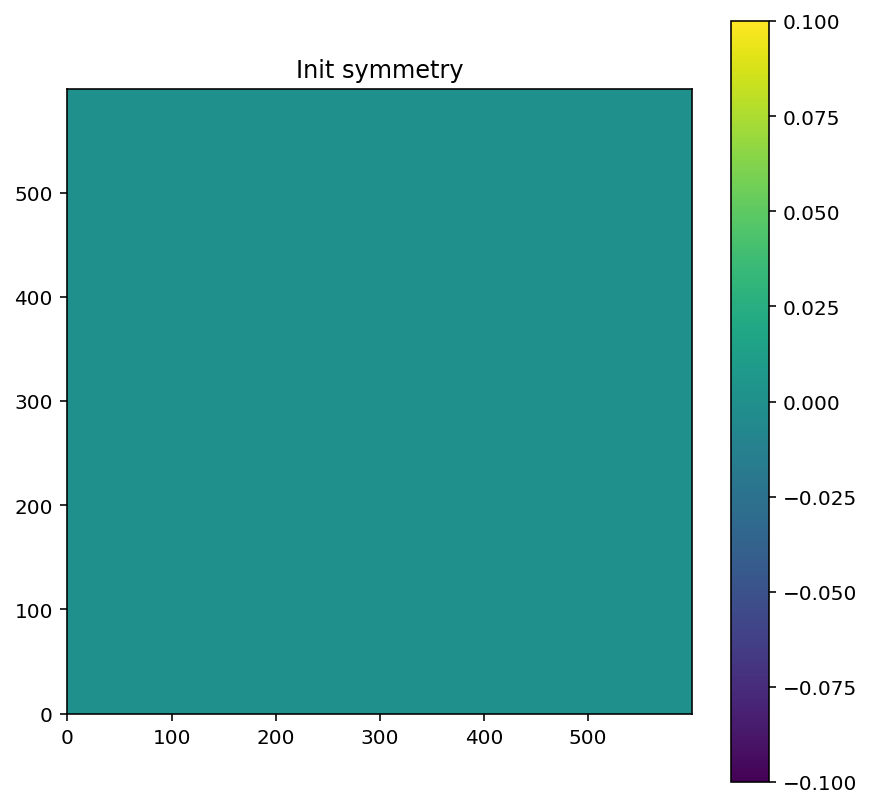

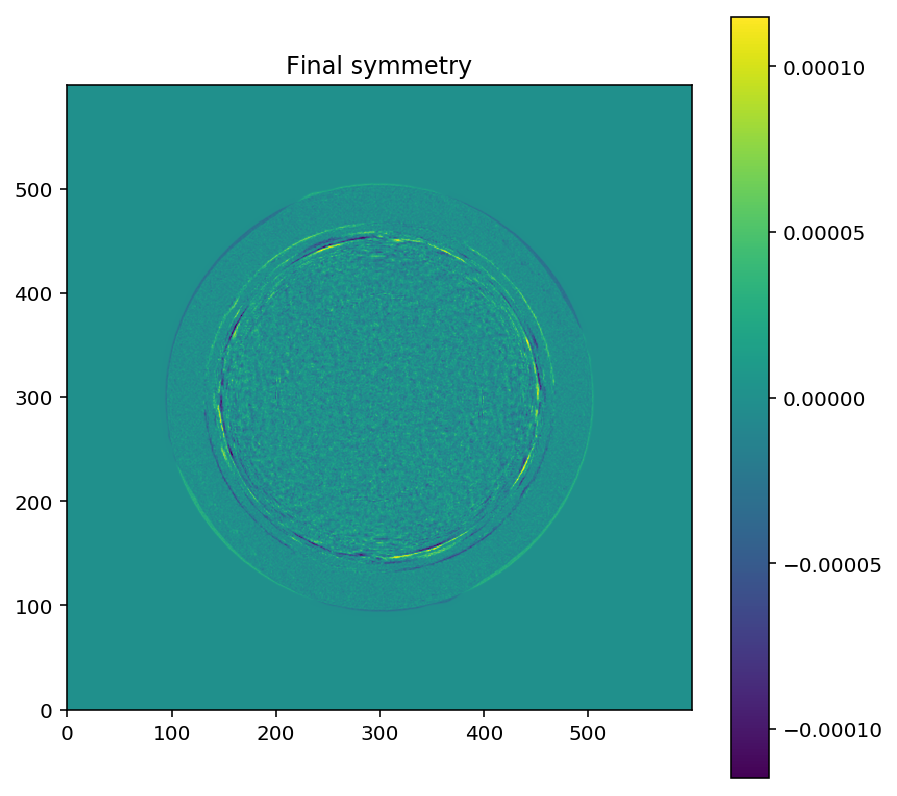

In [10]:
#Initialize simulator
if 'kp07_sim' in globals():
    kp07_sim.cleanUp()
reload(KP07)
kp07_sim = KP07.KP07(**sim_args, **init_args)

plot_symmetric(kp07_sim, "Init symmetry")

t = kp07_sim.step(sub_T)

plot_symmetric(kp07_sim, "Final symmetry")


In [11]:
if 'kp07_sim' in globals():
    kp07_sim.cleanUp()

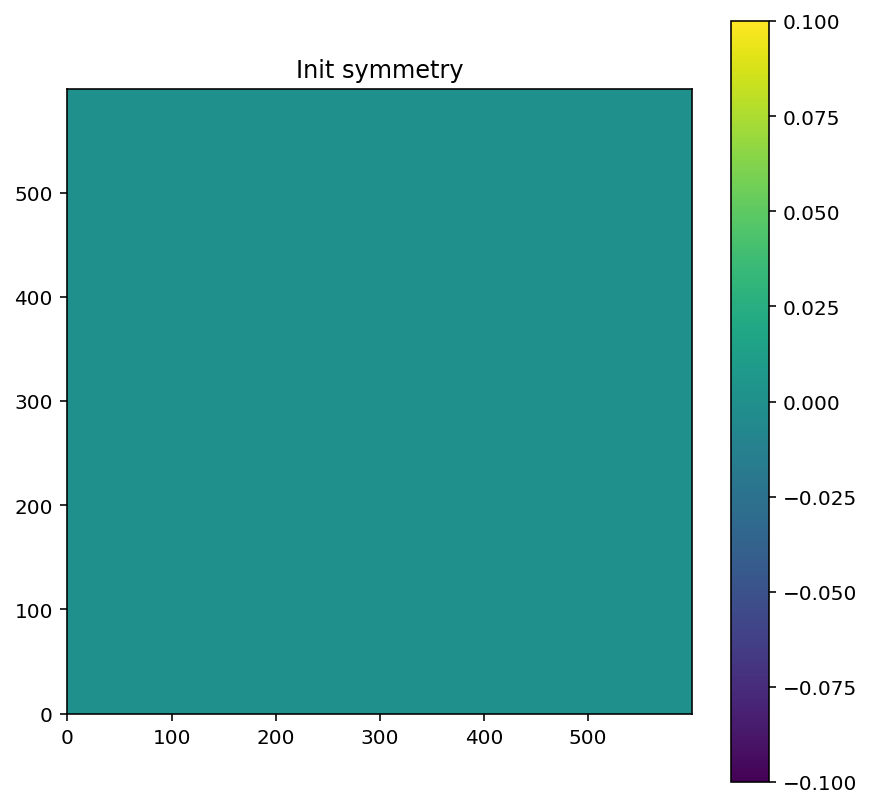

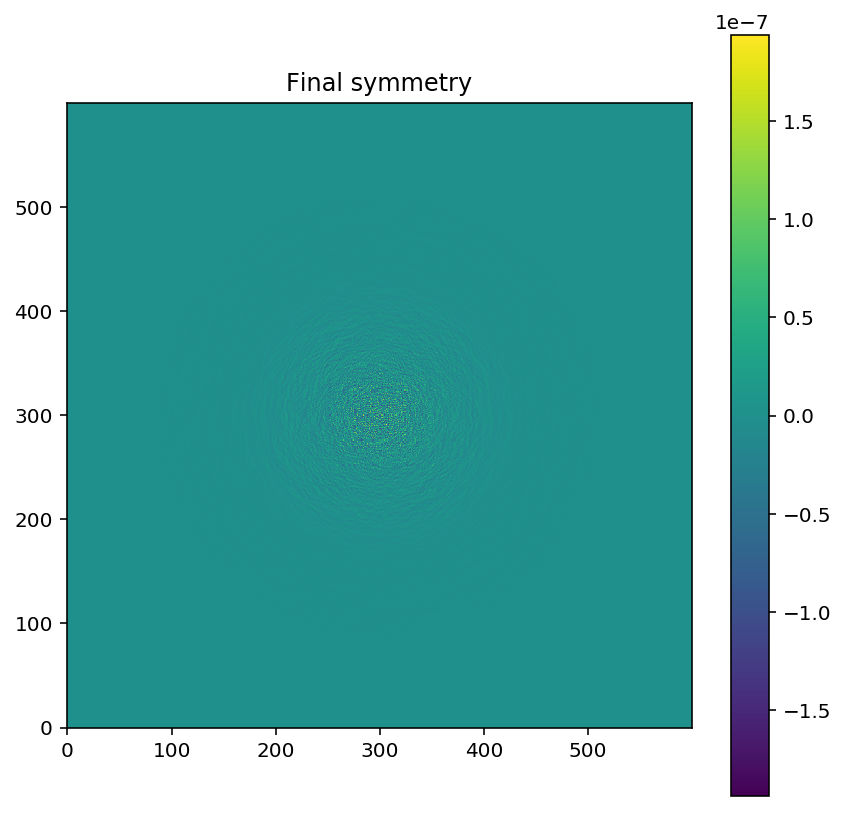

In [12]:
#Centered in time, centered in space

ctcs_ghosts = [1,1,1,1]
ctcs_dataShape = (ny + ctcs_ghosts[0]+ctcs_ghosts[2], 
                  nx + ctcs_ghosts[1]+ctcs_ghosts[3])

ctcs_h0 = np.ones(ctcs_dataShape, dtype=np.float32, order='C') * H0;
#addTopographyBump(h0, nx, ny, dx, dy, ghosts, 40)

ctcs_eta0 = np.zeros(ctcs_dataShape, dtype=np.float32, order='C');
ctcs_u0 = np.zeros((ctcs_dataShape[0], ctcs_dataShape[1]+1), dtype=np.float32, order='C');
ctcs_v0 = np.zeros((ctcs_dataShape[0]+1, ctcs_dataShape[1]), dtype=np.float32, order='C');

#initialConditions(cdklm_eta0, nx, ny, dx, dy, ghosts[1], ghosts[0])#
addWideDebugBump(ctcs_eta0, nx, ny, dx, dy, 0.5, 0.5, 1e5, ctcs_ghosts)


ctcs_init_args = {
    'eta0': ctcs_eta0,
    'hu0' : ctcs_u0,
    'hv0' : ctcs_v0,
    'H'   : ctcs_h0
}

#Initialize simulator
if 'ctcs_sim' in globals():
    ctcs_sim.cleanUp()
reload(CTCS)
ctcs_sim = CTCS.CTCS(**sim_args, **ctcs_init_args)

plot_symmetric(ctcs_sim, "Init symmetry")

t = ctcs_sim.step(sub_T)

plot_symmetric(ctcs_sim, "Final symmetry")



In [13]:
ctcs_sim.cleanUp()